# A Neural Network for Regression (Estimate blood pressure from PPG signal)


Having gained some experience with neural networks, let us train a network that estimates the blood pressure from a PPG signal window.

All of your work for this exercise will be done in this notebook.

# A Photoplethysmograph (PPG) signal

A PPG (photoplethysmograph) signal is a signal obtained with a pulse oximeter, which illuminates the skin and measures changes in light absorption. A PPG signal carries rich information about the status of the cardiovascular health of a person, such as breadth rate, heart rate and blood pressure. An example is shown below, where you also see the blood pressure signal that we will estimate (the data also has the ECG signal, which you should ignore).

<img width="80%" src="PPG_ABG_ECG_example.png">


# Preparing the Dataset 

In this task, you are expected to perform the full pipeline for creating a learning system from scratch. Here is how you should construct the dataset:
* Download the dataset from the following website, and only take "Part 1" (since the whole dataset is too big): https://archive.ics.uci.edu/ml/datasets/Cuff-Less+Blood+Pressure+Estimation
* Take a window of size $W$ from the PPG channel between time $t$ and $t+W$. Let us call this $\textbf{x}_t$.
* Take the corresponding window of size $W$ from the ABP (arterial blood pressure) channel between time $t$ and $t+W$. Find the maxima and minima of this signal within the window (you can use "findpeaks" from Matlab or "find_peaks_cwt" from scipy). Here is an example window from the ABP signal, and its peaks:
 <img width="60%" src="ABP_peaks.png">
    
* Calculate the average of the maxima, call it $y^1_t$, and the average of the minima, call it $y^2_t$.
* Slide the window (by an amount that is on the order of a few samples) over the PPG signals and collect many training instances of the form $\{\textbf{x}_t, <y^1_t, y^2_t>\}$ instances. 
* This will be your input-output for training the network. In other words, your network outputs two values.

In [11]:
import random
import numpy as np
from ceng783.utils import load_BP_dataset
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.
from ceng783.neural_net_for_regression import TwoLayerNet

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 4], [2, 1, 4], [2, 1, 4]])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `ceng783/neural_net_for_regression.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the previous exercises: It takes the data and weights and computes the *regression* scores, the *squared error loss*, and the gradients on the parameters. 

To be more specific, you will implement the following loss function:

$$\frac{1}{N}\frac{1}{2}\sum_i\sum_{j} (o_{ij} - y_{ij})^2 + \lambda\frac{1}{2}\sum_j w_j^2,$$

where $i$ runs through the $N$ samples in the batch; $o_{ij}$ is the prediction of the network for the $i^{th}$ sample for output $j$, and $y_{ij}$ is the correct value; $\lambda$ is the weight of the regularization term.

The first layer uses ReLU as the activation function. The output layer does not use any activation functions.

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [13]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print( np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [17]:
loss, _ = net.loss(X, y, reg=0.1)
print ("Your loss: ", loss)
correct_loss = 13.2984798095
# should be very small, we get < 1e-10
print ('Difference between your loss and correct loss:')
print (np.sum(np.abs(loss - correct_loss)))

Your loss:  13.298479809544315
Difference between your loss and correct loss:
4.431477407251805e-11


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [18]:
from ceng783.utils import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name])
  print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 5.461899e-04
W2 max relative error: 3.757715e-04
b1 max relative error: 2.197973e-07
b2 max relative error: 1.443449e-06


# Load the PPG dataset for training your regression network

In [6]:
# Load the PPG dataset
# If your memory turns out to be sufficient, try loading a subset
#
# TODO: Open up ceng783/utils.py and fill in the `load_BP_dataset()' function.
#
def get_data(datafile, training_ratio=0.9, test_ratio=0.06, val_ratio=0.01):
  # Load the PPG training data 
  X, y = load_BP_dataset(datafile)
  # this is not what supposed to happen
  length = X.shape[0]
  concated = np.concatenate((X,y),axis=1)
  np.random.shuffle(concated)
  # Splitting into 0.7,0.1,0.2
  train_rat,val_rat = int(0.7*length),int(0.8*length)
   
  X_train = concated[:train_rat,:1000]
  y_train = concated[:train_rat,1000:]
  X_val   = concated[train_rat:val_rat,:1000]
  y_val   = concated[train_rat:val_rat,1000:]
  X_test  = concated[val_rat:,:1000]
  y_test  = concated[val_rat:,1000:]
  ################################################################
  # TODO: Split the data into training, validation and test sets #
  ################################################################
  pass
  #########    END OF YOUR CODE    ###############################
  ################################################################
  
  return X_train, y_train, X_val, y_val, X_test, y_test

datafile = 'ceng783/data/Part_1.mat' #TODO: PATH to your data file
input_size = 1000 # TODO: Size of the input of the network

X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile)
print ("Number of instances in the training set: ", len(X_train))
print ("Number of instances in the validation set: ", len(X_val))
print ("Number of instances in the testing set: ", len(X_test))

Loading : |##########|
Number of instances in the training set:  2100
Number of instances in the validation set:  300
Number of instances in the testing set:  600


# Now train our network on the PPG dataset

In [8]:
# Now, let's train a neural network

input_size = input_size
hidden_size = 500 # TODO: Choose a suitable hidden layer size
num_classes = 2 # We have two outputs
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=500, batch_size=200,
            learning_rate=1e-5, learning_rate_decay=0.95,
            reg=0.005, verbose=True)

# Predict on the validation set
#val_err = ... # TODO: Perform prediction on the validation set
val_err = np.sum(np.square(net.predict(X_val) - y_val), axis=1).mean()
print ('Validation error: ', val_err)

iteration 0 / 500: loss 9530.386957
iteration 100 / 500: loss 9552.134998
iteration 200 / 500: loss 1045.128574
iteration 300 / 500: loss 1062.212354
iteration 400 / 500: loss 1130.326789
Validation error:  2126.6970580287625


# Debug the training and improve learning
You should be able to get a validation error of ~16.

So far so good. But, is it really good? Let us plot the validation and training errors to see how good the network did. Did it memorize or generalize? Discuss your observations and conclusions. If its performance is not looking good, propose and test measures. This is the part that will show me how well you have digested everything covered in the lectures.

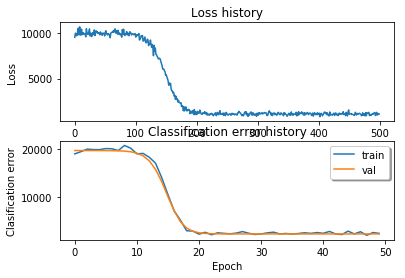

In [9]:
# Plot the loss function and train / validation errors
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
train = plt.plot(stats['train_err_history'], label='train')
val = plt.plot(stats['val_err_history'], label='val')
plt.legend(loc='upper right', shadow=True)
plt.title('Classification error history')
plt.xlabel('Epoch')
plt.ylabel('Clasification error')
plt.show()

# Finetuning and Improving Your Network (Bonus)
There are many aspects and hyper-parameters you can play with. Do play with them and find the best setting here.

In [ ]:
best_net = None # store the best model into this 
results = {}
best_val = np.inf
best_hps = (0,0,0)

learning_rates = [1, 1.4e-1,1.8e-2]
regularization_strengths = [0.1, 0.01, 0.001]
#lr_decay = [0.8,0.9,0.95,0.98] # I closed this due to time limitations, it gets too long
hidden_size = [500,700,1000]
k=0
while k<len(hidden_size):
    i=0
    while i< len(learning_rates):
        j = 0
        while j < len(regularization_strengths):
            t = 0
            #while t < len(lr_decay):
            print("\r k:{} i:{} j:{} t:{}".format(k,i,j,t),end="")
            net = TwoLayerNet(input_size, hidden_size[k], num_classes)
            stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=300, batch_size=64,
                learning_rate=learning_rates[i], learning_rate_decay=0.9,
                reg=regularization_strengths[j])
            
            val_acc   = np.sum(np.square(net.predict(X_val) - y_val), axis=1).mean()
            train_acc = np.sum(np.square(net.predict(X_train) - y_train), axis=1).mean()

            if best_val > val_acc:
                best_val = val_acc
                best_net = net
                #best_hps = (learning_rates[i], regularization_strengths[j],lr_decay[t])
                best_hps = (learning_rates[i], regularization_strengths[j])
            #results[(hidden_size[k],learning_rates[i], regularization_strengths[j],lr_decay[t])] = (train_acc, val_acc)
            results[(hidden_size[k],learning_rates[i], regularization_strengths[j])] = (train_acc, val_acc)
            #t+=1
            j=j+1
        i=i+1
    k=k+1
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################
print()
#for hs, lr, reg, lrd in sorted(results):
for hs, lr, reg in sorted(results):
    #train_accuracy, val_accuracy = results[(hs,lr, reg,lrd)]
    train_accuracy, val_accuracy = results[(hs,lr, reg)]
    print ('hs: %e lr: %e reg: %e train accuracy: %f val accuracy: %f' % (
                hs,lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

In [ ]:
net = TwoLayerNet(input_size, 700, num_classes)
stats = best_net.train(X_train, y_train, X_val, y_val,
                num_iters=5000, batch_size=200,
                learning_rate=best_hps[0], learning_rate_decay=0.9,
                reg=0.05,verbose=True)

In [ ]:
# Plot the loss function and train / validation errors
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
train = plt.plot(stats['train_err_history'], label='train')
val = plt.plot(stats['val_err_history'], label='val')
plt.legend(loc='upper right', shadow=True)
plt.title('Classification error history')
plt.xlabel('Epoch')
plt.ylabel('Clasification error')
plt.show()

## 
